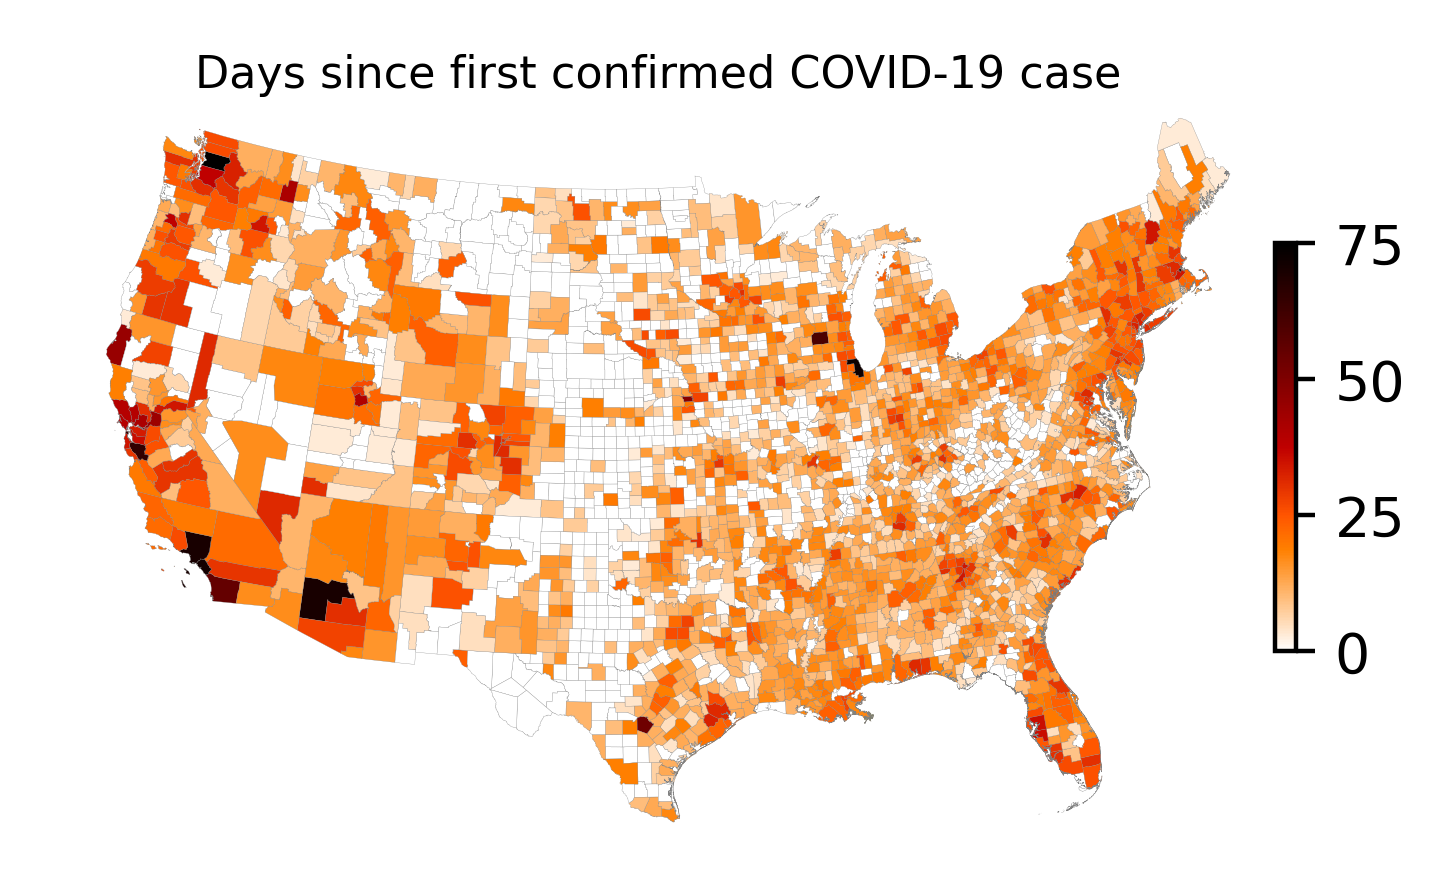

In [172]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import us

# Find number of days since "date"
def days_since(s_date, end_date):
    # If county is missing data
    if not isinstance(s_date, str):
        return -1
    delta = end_date - date.fromisoformat(s_date)
    
    return delta.days

# Load shapefile data
def load_shapefile(filepath):
    shapefile = "shapefiles/c_02jn20.shp"
    map_df = gpd.read_file(shapefile)

    # Filter out Alaska, Puerto Rico, and Hawai'i
    filter_indices = map_df[(map_df['STATE'] == 'AK') | (map_df['STATE'] == 'PR') | (map_df['STATE'] == 'HI')].index
    map_df.drop(filter_indices, inplace=True)

    # Change CRS to equal area
    map_df = map_df.to_crs("EPSG:2163")
    
    return map_df

# Load NY Times COVID-19 data
def load_cases_data(filepath):
    cases_df = pd.read_csv(filepath)

    # Keep only first date from each county
    cases_df.drop_duplicates(subset=["county", "state"], keep="first", inplace=True)

    # Filter out unneeded columns
    cases_df.drop(columns=["fips", "cases", "deaths"], inplace=True)

    # Rename "count" label to match map_df
    cases_df.rename(columns={"county": "COUNTYNAME"}, inplace=True)

    # Add column for state abbreviations which matches column in map_df
    cases_df['STATE'] = cases_df.apply (lambda row: us.states.lookup(row['state']).abbr, axis=1)
    
    return cases_df

def make_merged_df(maps_df, cases_df, end_date):
    # Merge map data with cases data
    merged_df = map_df.join(cases_df.set_index(["COUNTYNAME", "STATE"]), on=["COUNTYNAME", "STATE"])

    # Add column for days since first recorded infection
    merged_df["days_since_p0"] = merged_df.apply (lambda row: days_since(row["date"], end_date), axis=1)
    
    return merged_df

def make_plot(maps_df, cases_df):
    # Merge map and cases data
    merged_df = make_merged_df(maps_df, cases_df, date.today())
    
    # Set figure properties
    dpi = 400
    px, py = 1920, 1080
    w, h = px / dpi, py / dpi
    fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=dpi)

    #Set axis limits
    x_0, y_0 = 200000, -600000
    x_size, y_size = 4600000, 2900000
    buffer = 200000
    x_lim_left, x_lim_right = x_0 - (x_size/2) - buffer, x_0 + (x_size/2) + buffer
    y_lim_bottom, y_lim_top = y_0 - (y_size/2) - buffer, y_0 + (y_size/2) + buffer
    ax.set_xlim(x_lim_left, x_lim_right)
    ax.set_ylim(y_lim_bottom, y_lim_top)

    ax.axis("off")
    plt.title("Days since first confirmed COVID-19 case", fontdict={"fontsize": "8", "fontweight": "4"}, y=0.9)

    # Create colorbar as a legend
    cmap = "gist_heat_r"
    d_min, d_max = 0, max(merged_df.apply (lambda row: row["days_since_p0"], axis=1))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=d_min, vmax=d_max))
    sm._A = []
    # add the colorbar to the figure
    fig.colorbar(sm, shrink=0.5, pad=0.0)

    merged_df.plot(column="days_since_p0", cmap=cmap, linewidth=0.05, ax=ax, edgecolor="0.5")
    fig.savefig("map_export.png", dpi=dpi)
    
def main():
    shapefile = "shapefiles/c_02jn20.shp"
    cases_csv = "data/us-counties.csv"
    
    map_df = load_shapefile(shapefile)
    cases_df = load_cases_data(cases_csv)
    make_plot(map_df, cases_df)

if __name__ == '__main__':
    main()